In [ ]:
import os
import glob
from sklearn.model_selection import train_test_split
import torchvision as tv
import torch
import random
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
from collections import defaultdict
import time
from IPython.display import clear_output
import json
from torchsummary import summary
import random
import platform

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Примечание
- Все результаты получены в Google Colab на GPU A100, далее они были загружены в этот Jupyter notebook
- В датасете simpsons_dataset есть копия папки simpsons_dataset, которая была удалена

## Датасета персонажей мультфильма Симпсонов

[The Simpsons Characters Data](https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset)

[Easiest way to download kaggle data in Google Colab](https://www.kaggle.com/discussions/general/74235)

In [ ]:
if platform.system()=='Windows':
    slash = '\\'
else:
    slash = '/'

In [ ]:
data_dir = f"archive{slash}simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split(slash)[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


## Подберем аугментацию train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.

Цель: Val Accuracy > на 10 %
 - на занатии по feature extractors было 55 %
 - а для fine tuning - 84 %

Чтобы ухудшить качество на валидации сделаем следующее:
- возьмем только центральную часть изображения
- возьмем низкие параметры изменения яркости, контрастности и насыщенности, чтобы сети было труднее учиться и высокий параметр оттенка, чтобы сильно изменить цвета изображения
- будем случайно поварачивать изображение на 90 градусов и уменьшать масштаб до 70% (качество не ухудшается, но добавляется по краям пустая область)
- будем случайно масштабировать изображение до 70% (качество изображение будет ухудшаться)
- для половины изображений применим размытие

In [ ]:
input_size = 224

train_transform = tv.transforms.Compose([
    tv.transforms.Resize(input_size),
    tv.transforms.CenterCrop(input_size//2), 
    tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.5), 
    tv.transforms.RandomAffine(degrees=(0, 90), scale=(0.7, 1)),
    tv.transforms.RandomResizedCrop(size=input_size, scale=(0.7, 1.0)), 
    tv.transforms.Lambda(lambda x: x if torch.rand(1) < 0.5 else tv.transforms.GaussianBlur(kernel_size=21, sigma=(3, 3))(x)),
    tv.transforms.ToTensor(),
])

val_transform = tv.transforms.Compose([
    tv.transforms.Resize(input_size),
    tv.transforms.CenterCrop(input_size),
    tv.transforms.ToTensor(),
])

train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

num_classes = len(train_dataset.classes)

In [ ]:
def show_images(dataset):
    indices = random.sample(range(0, len(dataset)-1), 9)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
    class_dict = train_dataset.classes
    for i, ax in zip(indices, axes.flatten()):
        image, label = train_dataset[i]
        class_ = class_dict[label]
        image = image.numpy().transpose((1, 2, 0))
        ax.imshow(image)
        ax.set_title(f'label={label}, class={class_}')
        ax.axis('off')

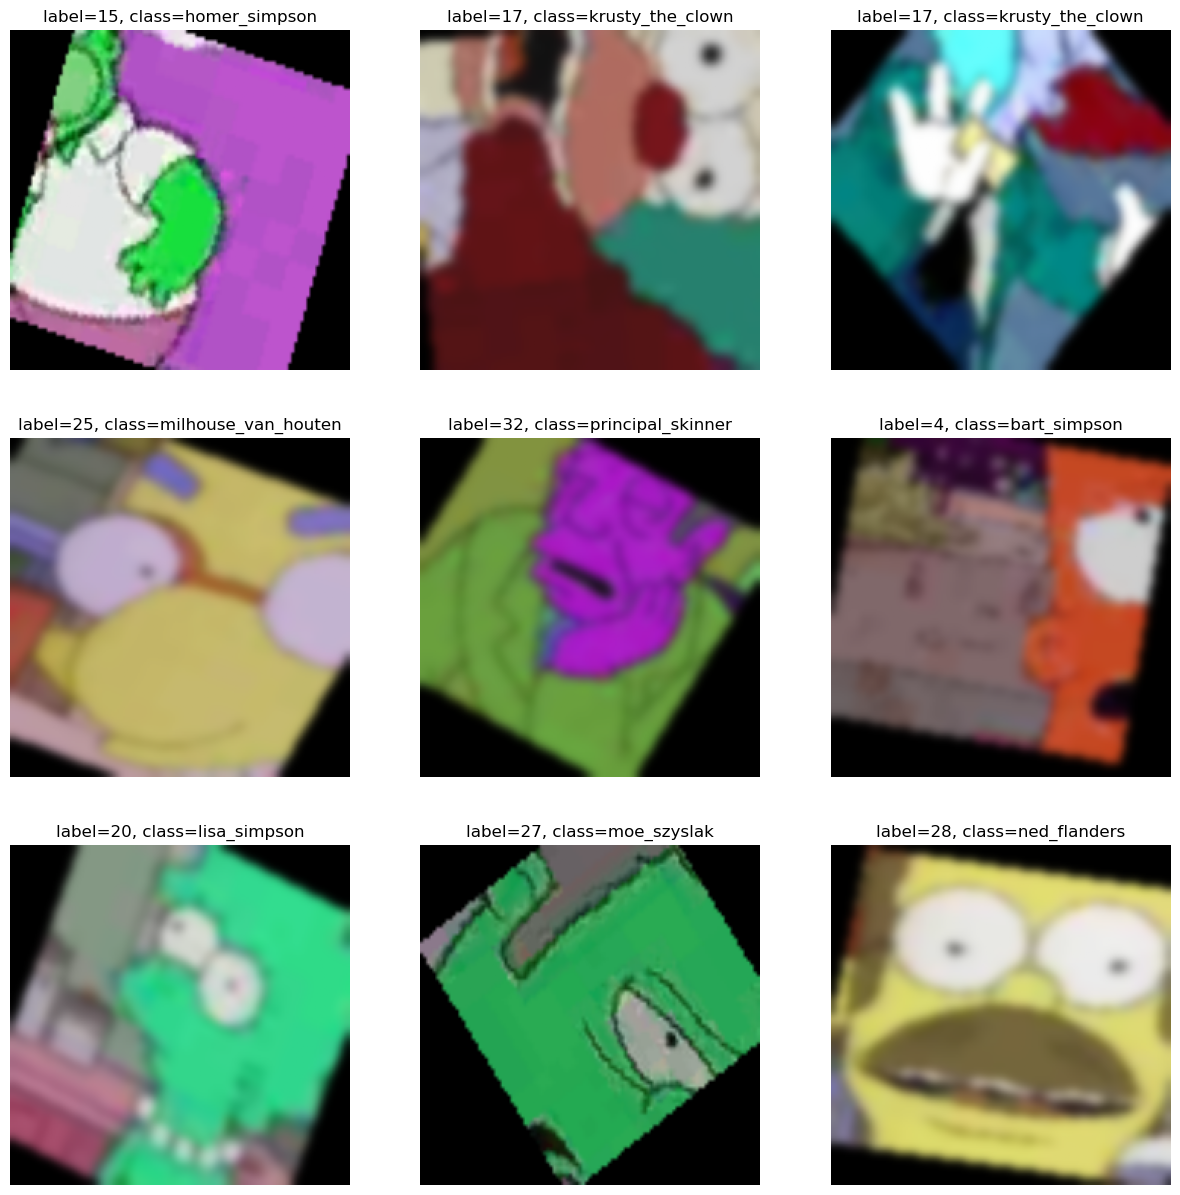

In [ ]:
show_images(train_dataset)

Как видно, изображения сильно изменились, но фанатам симпсонов еще можно распознать, где кто.

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('Точность', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

В функцию train добавляем код для StepLR и CyclicLR

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    scheduler = None,
    scheduler_name = None
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))
    history['took'] = []

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
            if scheduler_name=='CyclicLR':
                scheduler.step()
        
        if scheduler_name=='StepLR':
            scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        took = time.time() - start_time
        history['took'].append(took)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, took))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [ ]:
# функция для записи результатов
def data_write(data, file_path):
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

## Возьмем MobileNet архитектуру и применим к ней методы, которые разбирались на занятии.

### Feature Extractor StepLR

In [ ]:
fe_model = tv.models.mobilenet_v3_small(weights=tv.models.MobileNet_V3_Small_Weights.DEFAULT)
for name, param in fe_model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False
fe_model.classifier[3] = nn.Linear(in_features=fe_model.classifier[3].in_features, out_features=num_classes, bias=True)
fe_model = fe_model.to(device)

## Модифицируем код обучения, используя различные типы LR Schedulers

применим следующие типы LR Schedulers:
- [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR)
- [CyclicLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html#torch.optim.lr_scheduler.CyclicLR)

В первом эксперименте будем использовать StepLR.  
Согласно описанию он применяется после каждой эпохи.  
У нас 10 эпох, поэтому step_size установить в 3 и каждую эпоху уменьшаем lr с gamma=0.1

Epoch 10 of 10 took 149.366s
  training loss (in-iteration): 	2.749532
  validation loss (in-iteration): 	2.893476
  training accuracy: 			24.88 %
  validation accuracy: 			18.43 %


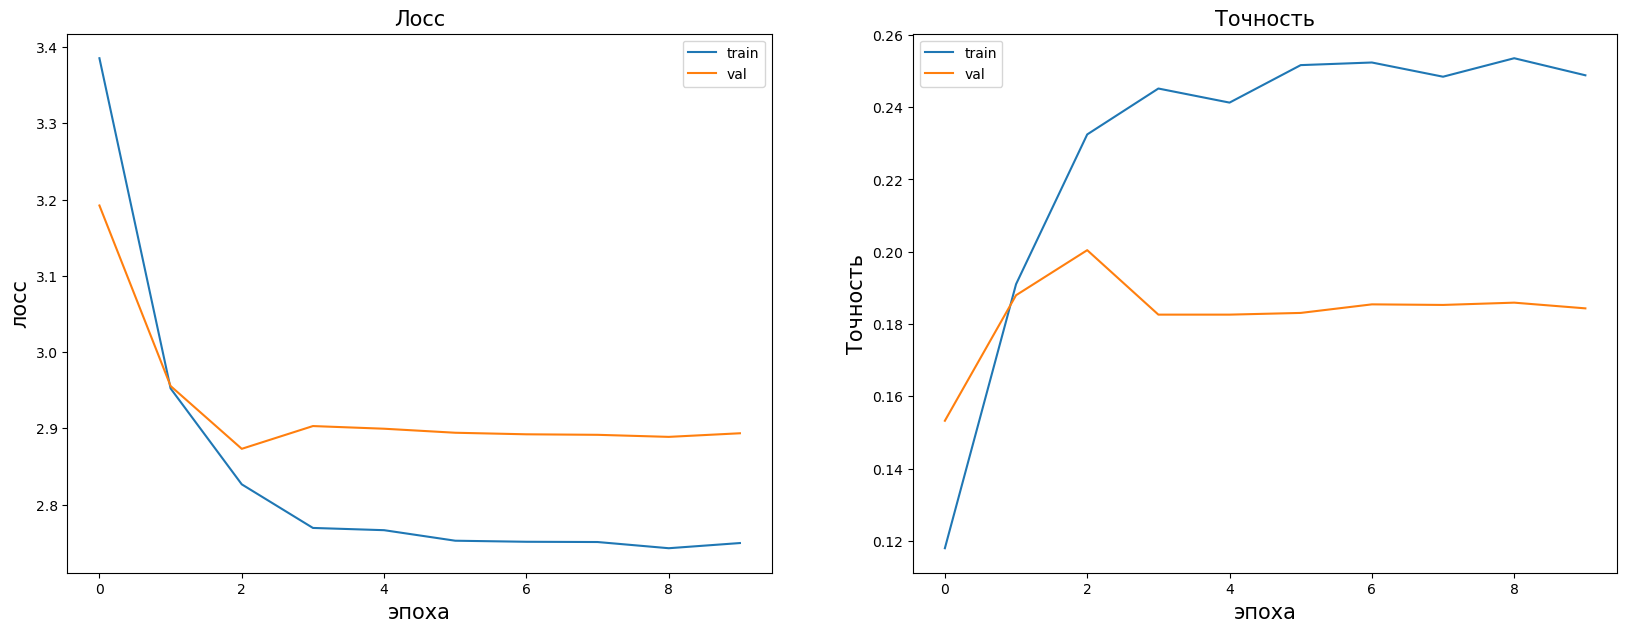

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen, 
    num_epochs=10,
    scheduler=scheduler,
    scheduler_name='StepLR'
)

In [ ]:
# запишем результат
save_directory = r'resources/v4'
os.makedirs(save_directory, exist_ok=True)
data_write(history, f"{save_directory}/fe_model_mobilenet_v3_small_StepLR_3_01_v4_history.json")

### Fine Tuning StepLR

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet', tv.models.mobilenet_v3_small(weights=tv.models.MobileNet_V3_Small_Weights.DEFAULT))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, num_classes))

fine_tuning_model = fine_tuning_model.to(device)

Epoch 10 of 10 took 154.316s
  training loss (in-iteration): 	2.085081
  validation loss (in-iteration): 	2.218918
  training accuracy: 			43.27 %
  validation accuracy: 			40.36 %


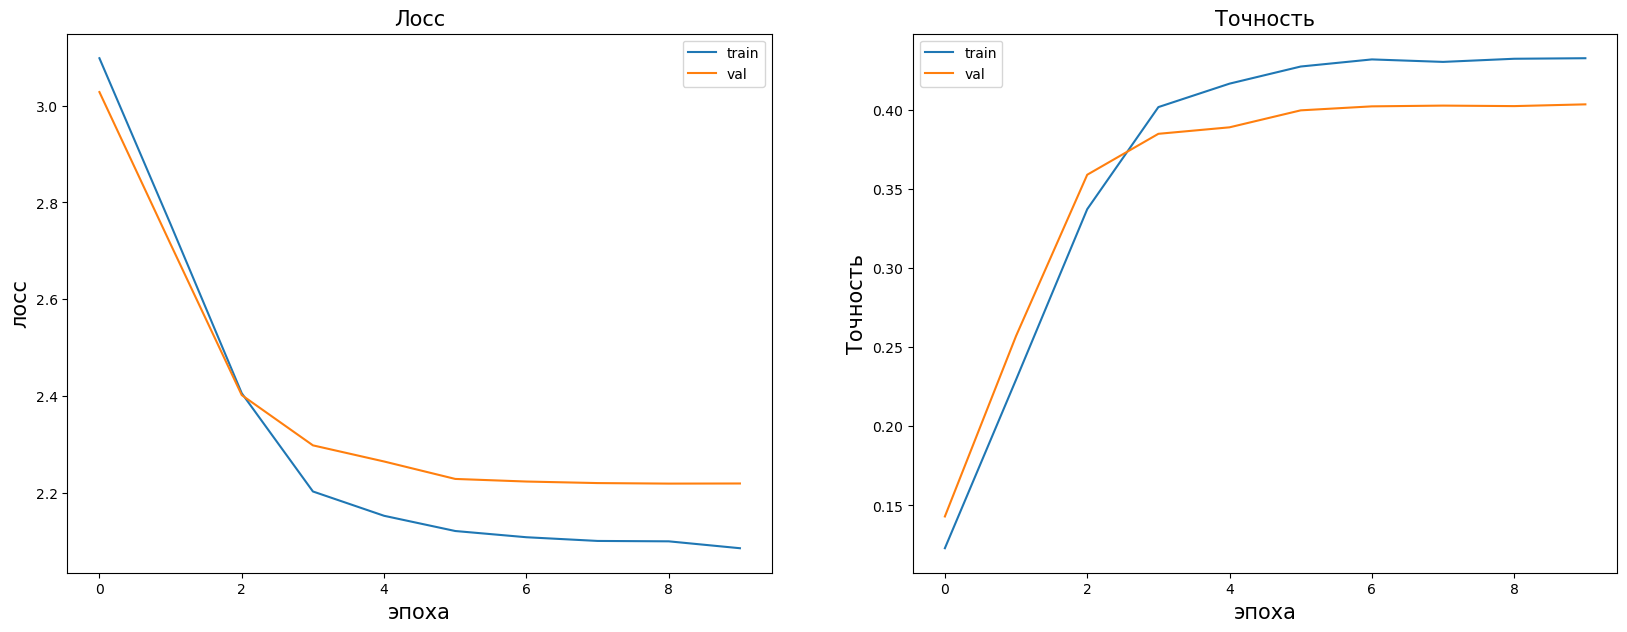

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10,
    scheduler=scheduler,
    scheduler_name='StepLR'
)

In [ ]:
data_write(history, f"{save_directory}/fine_tuning_model_mobilenet_v3_small_StepLR_3_01_v4_history.json")

## Проведем второй эксперимент с шедулером CyclicLR

Во втором эксперименте будем использовать CyclicLR.  
Согласно описанию он применяется после полного использования бача.  
Размер бача 64, всего изображений в train 14653 и итоге за эпоху будет 229 бачей. Рекомендуют делать изменение 4 или 5 раз за все эпохи: 229 * 10 / 4 = около 600

### Feature Extractor CyclicLR

Epoch 10 of 10 took 148.537s
  training loss (in-iteration): 	2.383167
  validation loss (in-iteration): 	2.869982
  training accuracy: 			33.51 %
  validation accuracy: 			22.93 %


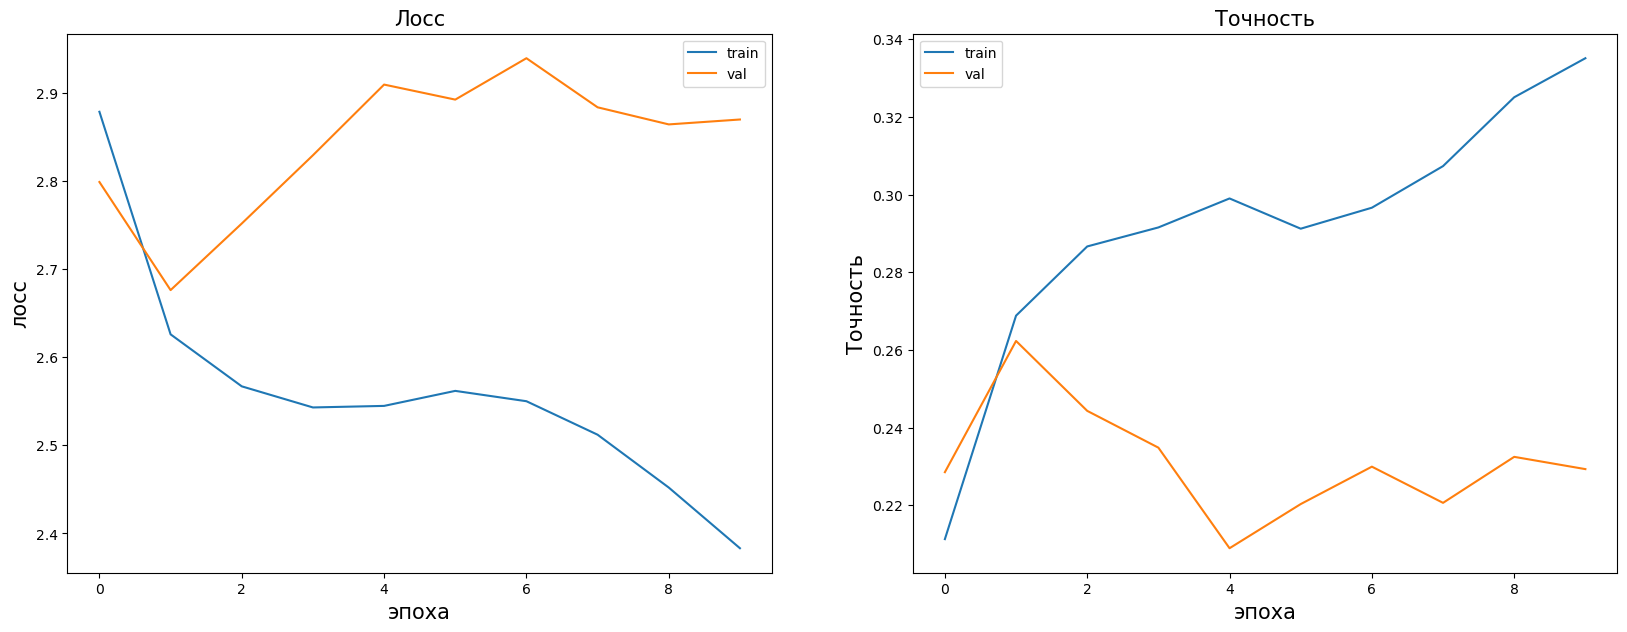

In [ ]:
fe_model = tv.models.mobilenet_v3_small(weights=tv.models.MobileNet_V3_Small_Weights.DEFAULT)
for name, param in fe_model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False
fe_model.classifier[3] = nn.Linear(in_features=fe_model.classifier[3].in_features, out_features=num_classes, bias=True)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=600, mode='triangular')

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen, 
    num_epochs=10,
    scheduler=scheduler,
    scheduler_name='CyclicLR'
)

In [ ]:
data_write(history, f"{save_directory}/fe_model_mobilenet_v3_small_CyclicLR_001_01_600_v4_history.json")

### Fine Tuning CyclicLR

Epoch 10 of 10 took 151.547s
  training loss (in-iteration): 	0.706027
  validation loss (in-iteration): 	1.260091
  training accuracy: 			80.97 %
  validation accuracy: 			67.96 %


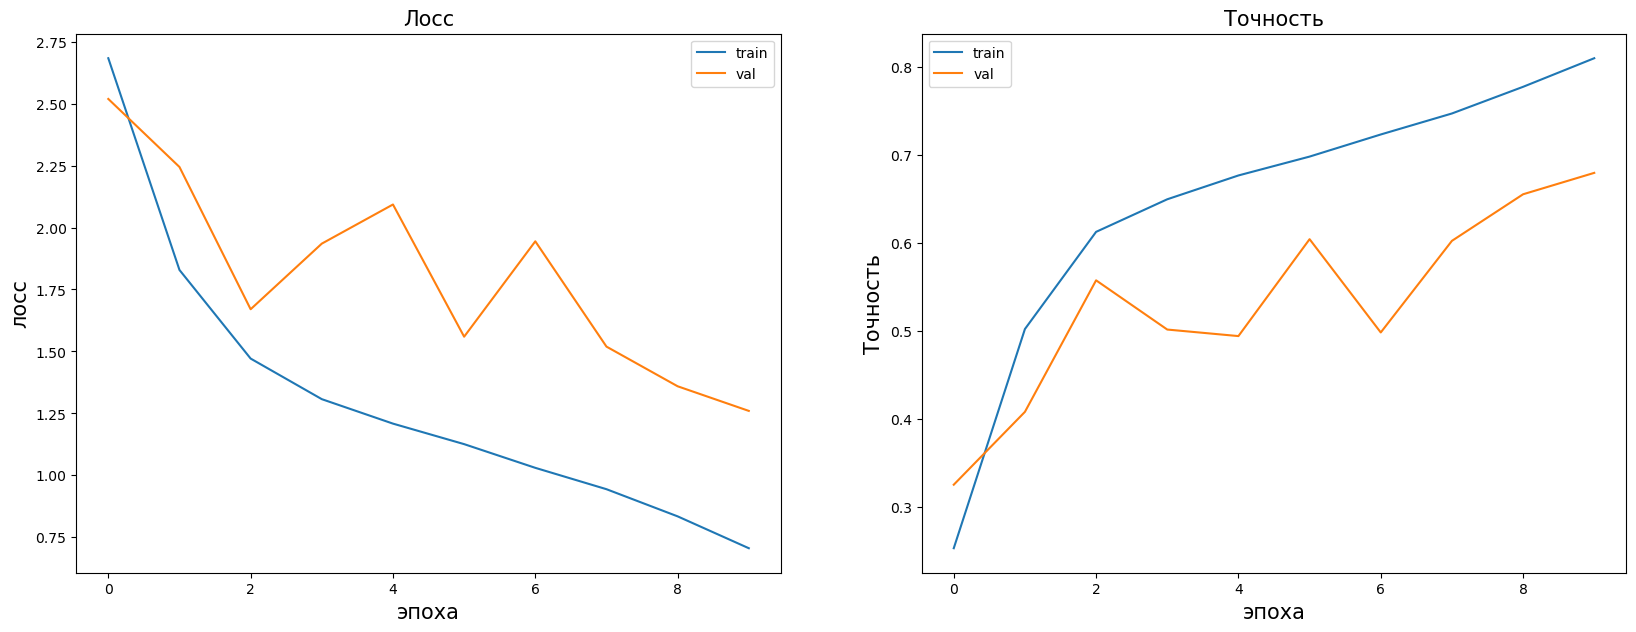

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet', tv.models.mobilenet_v3_small(weights=tv.models.MobileNet_V3_Small_Weights.DEFAULT))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, num_classes))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=600, mode='triangular')

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen, 
    num_epochs=10,
    scheduler=scheduler,
    scheduler_name='CyclicLR'
)

In [ ]:
data_write(history, "fine_tuning_model_mobilenet_v3_small_CyclicLR_001_01_600_v4_history.json")

## Сведем все результаты вместе для сравнения

In [ ]:
files = glob.glob(f"{save_directory}/*.json")
files

['resources/v4\\fe_model_mobilenet_v3_small_CyclicLR_001_01_600_v4_history.json',
 'resources/v4\\fe_model_mobilenet_v3_small_StepLR_3_01_v4_history.json',
 'resources/v4\\fine_tuning_model_mobilenet_v3_small_CyclicLR_001_01_600_v4_history.json',
 'resources/v4\\fine_tuning_model_mobilenet_v3_small_StepLR_3_01_v4_history.json']

In [ ]:
file_json_list = []
for file in files:
    if 'fine_tuning_' in file and 'StepLR' in file:
        name = 'ft (StepLR)'
    elif 'fine_tuning_' in file and 'CyclicLR' in file:
        name = 'ft (CyclicLR)'
    elif 'fe_' in file and 'StepLR' in file:
        name = 'fe (StepLR)'
    elif 'fe_' in file and 'CyclicLR' in file:
        name = 'fe (CyclicLR)'
    with open(file) as f: 
        file_json = json.load(f)
        file_json['name'] = name
        file_json_list.append(file_json)

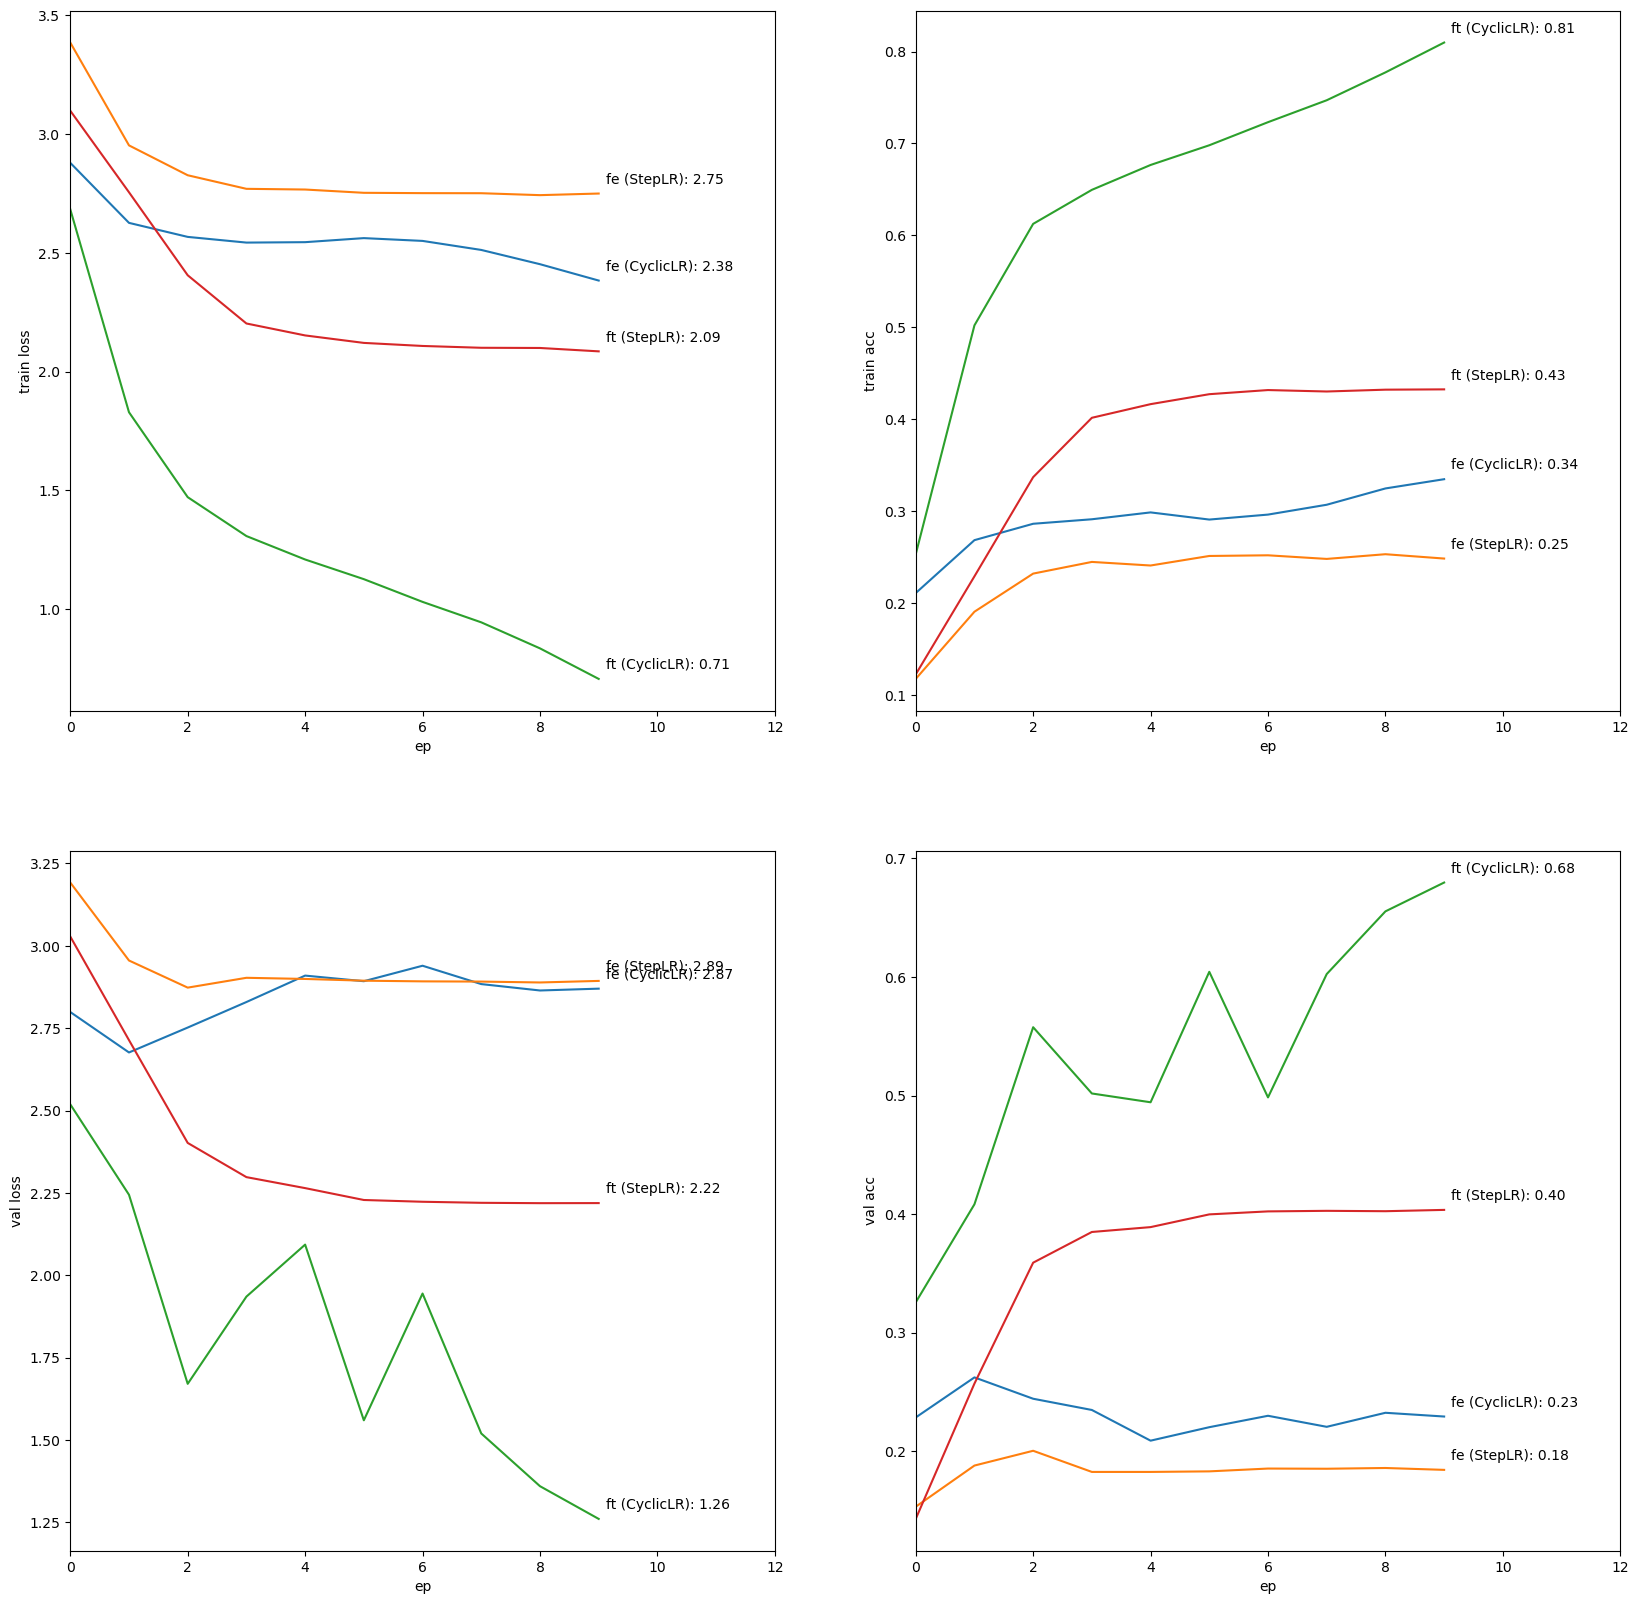

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
ylabels = ['train loss', 'train acc', 'val loss', 'val acc']
for file_json in file_json_list:
    for ax, ylabel in zip(axes.flatten(), ylabels):
        ax.set_xlabel('ep')
        ax.set_ylabel(ylabel)
        y = file_json[ylabel.split(' ')[1]][ylabel.split(' ')[0]]
        x = range(len(y))
        label = file_json['name']
        ax.plot(x , y, label=label)
#         ax.legend()
        ax.set_xlim(0, len(y)+2)
        ax.annotate(f'{label}: {y[-1]:.2f}', xy=(x[-1], y[-1]), xytext=(5, 5),
                    textcoords='offset points', ha='left', va='bottom')

## Выводы по результатам проведённых экспериментов

- Модель Feature Extractor дает худший результат, так как обучается только конец сети (пару слоев).
- Видно, что для Feature Extractor сначала качесто валидационных данных на первых эпохах выше, чем потом. Я думаю, это из-за того, что сначала, когда сеть не адаптировалась к новым сильно искаженным данным, она дает хорошоший результат, так как мы взяли готовую хорошо обученную модель. Но потом, когда начали обучать выходные слои на искаженных данных, то точность на валидационных картинках упала.
- Графики с шедулером CyclicLR для валидационных данных скачут. Возможно, это из-за того, что мы каждые 600 бачей меняем скорость обучения с одной до другой величины.
- Графики с StepLR по сравнению с CyclicLR со второй половины эпох имеют более ровный тренд, это из-за того, что скорость обучения к этому моменту сильно упала и, скорее всего, мы застряли в каком-то одном локальном минимуме

## Итог:
- LR Schedulers применяются корректно (при встраивании LR шедулеров не возникло ошибок), проведено 2 эксперимента
- при изменении аугментацией Accuracy сильно (> 10 процентов) уменьшилась:
    - на занатии по feature extractors было 55 % у нас 23 %
    - а для fine tuning - 84 % у нас - 68%
- проведено обучение и дообучение сети MobileNet, получены сравнимые результаты. Разница между Feature Extractor и FineTuning для StepLR 22 %, а для CyclicLR - 45 %. На занятии было 29 %.
- составлен анализ проведённых экспериментов